# Neural networks : Echo State Network

## A brief introduction

An <i>echo state network</i> is a Recurrent Neural Network, whose reservoir contains randomly generated neurons, and where only the weights of the outputs can be modified. In this notebook, we will focus on an ESN model developped by Mantas Lukoševičius.

In [1]:
%matplotlib inline

## Module importation

We'll first import the modules we need. We will need the <i>%matplotlib inline</i> command, which allows to plot graphs directly into the notebook, and the modules <b>numpy</b> (numerical module allowing vectors and matrix handling), <b>matplotlib</b> (which will plot graphs), <b>scipy</b> (whose linalg method will allow the importation of linear algebra functions), and <b>IPython</b> widgets, allowing to interact in real time with the graphs by moving cursors.

In [2]:
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
by Mantas Lukoševičius 2012
http://minds.jacobs-university.de/mantas
---
Modified by Xavier Hinaut: 2015-2016
http://www.xavierhinaut.com
"""
#from numpy import *
import numpy as np
#from matplotlib.pyplot import *
import matplotlib.pyplot as plt
#import scipy.linalg
from scipy import linalg
#from numpy import linalg
from ipywidgets import *
from IPython.display import *

## Random reset

We will initiate a first pseudo-random value, depending on the current time when launching the algorithm. This will allow to ensure that two different launchs of the program will not give the same results.

In [3]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    # Set the seed
    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
        print(seed)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

## Creating a "Network" class

We create a <i>Network</i> class. When initialized, an object from this class will have 4 default attributes :
<ul><li><b>initLen</b>: number of initializing iterations;</li>
<li><b>trainLen</b>: number of training iterations;</li>
<li><b>testLen</b>: number of testing iterations;</li>
<li><b>data</b>: data file.</li></ul>

In [4]:
class Network(object):

    def __init__(self, trainLen=2000, testLen=2000, initLen=100) :
        self.initLen = initLen
        self.trainLen = trainLen
        self.testLen = testLen        
        self.data = np.loadtxt("MackeyGlass_t17.txt")

nw = Network()

## Dynamic plot of a data sample

We will now display a sample of data from the <i>data</i> file, by plotting the first 5,000 iterations. You can change the number of iterations by moving the cursor.

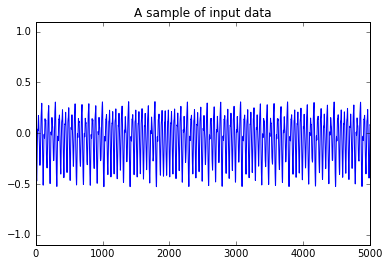

<function __main__.plot_figure>

In [5]:
# plot some of it
def plot_figure(f) :
    plt.figure(0).clear()
    plt.plot(nw.data[0:f])
    plt.ylim([-1.1,1.1])
    plt.title('A sample of input data')
    plt.show()
    
interact(plot_figure, f=(1000,10000,1000))

## Variables

Let's create our reservoir. The default number of neurons contained in the reservoir is 300 (<b>resSize</b>), while the input and the output contain both one neuron (<b>inSize and outSize</b>). The network can be represented like this : <img src="Reservoir3.png"></img>

Input neurons are connected to reservoir neurons. We save the weights of every connection in a <b style="color:#99cc00">W<sub>in</sub></b> matrix (dim. inSize x resSize). Weights of the connections from reservoir to the output are saved in the <b style="color:#ff0000">W<sub>out</sub></b> matrix (dim. resSize x outSize). Into the reservoir itself, one neuron is linked to every other : weights are saved in the <b style="color:#ffcc00">W</b> matrix (dim. resSize x resSize).

In [2]:
# generate the ESN reservoir
nw.inSize = nw.outSize = 1 #input/output dimension
nw.resSize = 300 #reservoir size (for prediction)
#resSize = 1000 #reservoir size (for generation)
nw.a = 0.3 # leaking rate 
nw.spectral_radius = 1.25
nw.input_scaling = 1.
nw.reg =  1e-8 #None # regularization coefficient, if None, pseudo-inverse
#is use instead of ridge regression

nw.mode = 'prediction'
#mode = 'generative'

#change the seed, reservoir performances should be averaged accross
#at least 20 random instances (with the same set of parameters)
seed = None #42

set_seed(seed) #random.seed(seed) 

NameError: name 'nw' is not defined

## Graph plotting functions

We define different functions that will be used later in the program.

In [34]:
# plot some signals
def plot_figure1(nw) :
    nw = compute_network(nw)
    plt.figure(1).clear()
    plt.plot( nw.data[nw.trainLen+1:nw.trainLen+nw.testLen+1], 'g' )
    plt.plot( nw.Y.T, 'b' )
    plt.title('Target and generated signals $y(n)$ starting at $n=0$')
    if nw.mode == 'generative':
        plt.legend(['Target signal', 'Free-running predicted signal'])
    elif nw.mode == 'prediction':
        plt.legend(['Target signal', 'Predicted signal'])

def plot_figure2(nw) :
    nw = compute_network(nw)
    plt.figure(2).clear()
    #plot( X[0:20,0:200].T )
    plt.plot( nw.X[0:2,0:2000].T ) #xav
    plt.legend(["biais", "input"])
    plt.ylim([-1.1,1.1])
    plt.title('Input $\mathbf{u}(n)$ and bias for 2000 time steps')

def plot_figure3(nw,nb) :
    nw = compute_network(nw)
    plt.figure(3).clear()
    plt.plot( nw.X[2:2+nb,0:200].T )
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neurons ID 0 to '+str(nb-1)+' for 200 time steps')

def plot_figure4(nw,num) :
    nw = compute_network(nw)
    plt.figure(4).clear()
    plt.plot( nw.X[2+num,:].T )
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neuron ID '+str(num)+' for all time steps')

def plot_figure5(nw,l) :
    nw = compute_network(nw)
    plt.figure(5).clear()
    print(nw.X.shape)
    plt.plot( nw.X[2:,0:l].T )
    plt.ylim([-1.1,1.1])
    plt.title('All reservoir activations $\mathbf{x}(n)$ for '+str(l)+' time steps')

def plot_figure6(nw) :
    nw = compute_network(nw)
    plt.figure(6).clear()
    plt.bar( range(1+nw.inSize+nw.resSize), nw.Wout.T )
    plt.title('Output weights $\mathbf{W}^{out}$')

## Processing the network with the parameters

We first randomly generate <b style="color:#99cc00">W<sub>in</sub></b> input weights, and <b style="color:#ffcc00">W</b> reservoir weights. Then, we scale the <b style="color:#ffcc00">W</b> weights with the spectral radius.

In [42]:
def initialization(nw) :

    nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * nw.input_scaling
    nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    
    # Option 1 - direct scaling (quick&dirty, reservoir-specific):
    #W *= 0.135 
    # Option 2 - normalizing and setting spectral radius (correct, slow):
    print('Computing spectral radius...',)
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    #np_rhoW = max(abs(np.linalg.eig(W)[0]))
    #print("Difference between scipy and numpy .eig() method: scipy="+str(rhoW)+" numpy="+str(np_rhoW)
    print('done.')
    nw.W *= nw.spectral_radius / rhoW
    
    #Matrice 
    # allocated memory for the design (collected states) matrix
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    # set the corresponding target matrix directly
    nw.Yt = nw.data[None,nw.initLen+1:nw.trainLen+1]

    # run the reservoir with the data and collect X
    nw.x = np.zeros((nw.resSize,1))

    print("a :", nw.a, "- spectral radius :", nw.spectral_radius, "- input scaling :", nw.input_scaling)   
    
    return(nw)

We continue with a training phase, which duration depends of the <b>trainLen</b> value. Data from the <i>data</i> file are used in input. The algorithm changes every reservoir neuron value on every step, depending on the <b style="color:#99cc00">W<sub>in</sub></b>. weights, using the following formula :</br></br>
$$x_{n} = (1-\alpha)x_{n-1} \times \alpha \tanh(W_{in}.u_{n-1}) + W.x_{n-1}$$
Once the initialization span (<b>initLen</b>) is over, the algorithm begins to modify the X matrix, which collects neurons states during the simulation : the first neuron is the bias (1), the second one is the input, and every other are the x matrix :
$$X_{n} = [1;u_{n};x_{n}]$$

In [1]:
def train_input(nw) :
    #APPRENTISSAGE
    for t in range(nw.trainLen):
        #Données en entrée, issues de data
        nw.u = nw.data[t]
        print(np.vstack((1,nw.u)).shape)
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot( nw.W, nw.x ) )
        #Au bout d'un certain temps, on modifie X
        if t >= nw.initLen:
            nw.X[:,t-nw.initLen] = np.vstack((1,nw.u,nw.x))[:,0]
            
    return(nw)

Now, we record output weights <b style="color:#ff0000">W<sub>out</sub></b>.
$$W_{out} = (Y_{t}.X^{T}).(X.X^{T} + reg.I)^{-1}$$


In [2]:
def train_output(nw) :
    # train the output
    nw.X_T = nw.X.T
    if nw.reg is not None:
        # use ridge regression (linear regression with regularization)
        nw.Wout = np.dot(np.dot(nw.Yt,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + \
            nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
        ### Just if you want to try the difference between scipy.linalg and numpy.linalg 
        ### which does not give the same results. For more info, see :
        ### https://www.scipy.org/scipylib/faq.html#why-both-numpy-linalg-and-scipy-linalg-what-s-the-difference
        # np_Wout = np.dot(np.dot(Yt,X_T), np.linalg.inv(np.dot(X,X_T) + \
        # reg*np.eye(1+inSize+resSize) ) )
        # print("Difference between scipy and numpy .inv() method:\n\tscipy_mean_Wout="+\
        # str(np.mean(Wout))+"\n\tnumpy_mean_Wout="+str(np.mean(np_Wout))
    else:
        # use pseudo inverse
        nw.Wout = np.dot(nw.Yt, linalg.pinv(nw.X) )
        
    return(nw)

When the training is over, we launch network testing.

In [3]:
def test(nw) :
    # run the trained ESN in a generative mode. no need to initialize here, 
    # because x is initialized with training data and we continue from there.
    nw.Y = np.zeros((nw.outSize,nw.testLen))
    nw.u = nw.data[nw.trainLen]
    for t in range(nw.testLen):
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot(nw.W,nw.x ) )
        nw.y = np.dot(nw.Wout, np.vstack((1,nw.u,nw.x)) )
        nw.Y[:,t] = nw.y
        if nw.mode == 'generative':
            # generative mode:
            nw.u = nw.y
        elif nw.mode == 'prediction':
            ## predictive mode:
            nw.u = nw.data[nw.trainLen+t+1] 
        else:
            raise(Exception, "ERROR: 'mode' was not set correctly.")

    # compute MSE for the first errorLen time steps
    errorLen = 500
    mse = sum( np.square( nw.data[nw.trainLen+1:nw.trainLen+errorLen+1] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    
    return(nw)

In [4]:
def compute_network(nw) :
    nw = initialization(nw)
    nw = train_input(nw)
    nw = train_output(nw)
    nw = test(nw)    
    return(nw)

## Graph 1: Comparison between expected and estimated outputs

In [5]:
var1 = FloatSlider(value=300, min=0, max=1000, step=1, description='resSize')
var2 = FloatSlider(value=100, min=0, max=2000, step=1, description='initLen')
var3 = FloatSlider(value=2000, min=0, max=2000, step=1, description='trainLen')
valid = Button(description='Valider')

def trace_graph1(_) :
    clear_output()
    nw.resSize=int(var1.value)
    nw.initLen=int(var2.value)
    nw.trainLen=int(var3.value)
    plot_figure1(nw)
    
valid.on_click(trace_graph1)
    
display(var1)
display(var2)
display(var3)
display(valid)

NameError: name 'FloatSlider' is not defined

## Graph 2: Plotting input data

On affiche, pour les 2000 premières itérations, les valeurs en entrée et le biais (toujours égal à 1).

Computing spectral radius...
done.
a : 0.3 - spectral radius : 1.25 - input scaling : 1.0
MSE = 0.00223106920528


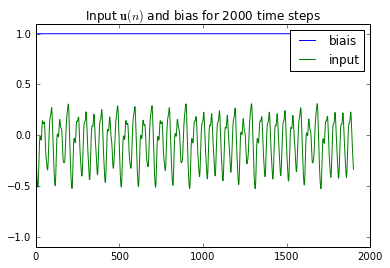

In [40]:
plot_figure2(nw)

## Graph 3: Plotting neurons activations (total)

Computing spectral radius...
done.
a : 0.5 - spectral radius : 1.25 - input scaling : 1.0
MSE = 2.78904241625e-09


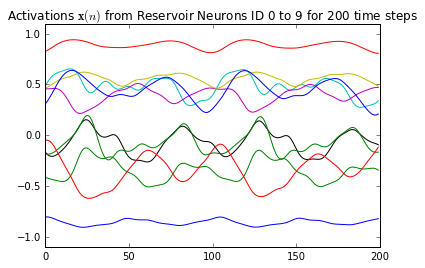

In [43]:
var4 = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='alpha')
var5 = FloatSlider(value=10, min=1, max=nw.resSize, step=1, description='nombre de neurones')
valid = Button(description='Valider')

def trace_graph3(_) :
    clear_output()
    nw.a=float(var4.value)
    nb=int(var5.value)
    plot_figure3(nw,nb)
    
valid.on_click(trace_graph3)
    
display(var4)
display(var5)
display(valid)

## Graph 4: Plotting single neuron activation

In [19]:
var10 = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='alpha')
var11 = FloatSlider(value=2, min=0, max=nw.resSize-1, step=1, description='neuron ID')
valid = Button(description='Valider')

def trace_graph4(_) :
    clear_output()
    nw.a=float(var10.value)
    num=int(var11.value)
    plot_figure4(nw,num)
    
valid.on_click(trace_graph4)
    
display(var10)
display(var11)
display(valid)

## Graph 5: Plotting every neuron activation

In [20]:
var13 = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='alpha')
var14 = FloatSlider(value=300, min=0, max=2000, step=1, description='resSize')
var15 = FloatSlider(value=200, min=0, max=nw.testLen-nw.initLen, step=10, description='time steps')
valid = Button(description='Valider')

def trace_graph5(_) :
    clear_output()
    nw.a=float(var13.value)
    nw.resSize=int(var14.value)
    l=int(var15.value)
    plot_figure5(nw,l)
    
valid.on_click(trace_graph5)
    
display(var13)
display(var14)
display(var15)
display(valid)

## Graph 6: Output weights at the end of the simulation

In [21]:
var16 = FloatSlider(value=0.5, min=0, max=1, step=0.05, description='alpha')
var17 = FloatSlider(value=300, min=0, max=1000, step=1, description='resSize')
var18 = FloatSlider(value=1000, min=0, max=2000, step=1, description='trainLen')
valid = Button(description='Valider')

def trace_graph6(_) :
    clear_output()
    nw.a=float(var16.value)
    nw.resSize=int(var17.value)
    nw.trainLen=int(var18.value)
    plot_figure6(nw)
    
valid.on_click(trace_graph6)
    
display(var16)
display(var17)
display(var18)
display(valid)